### This is a test notebook for receptive field reconstruction.

The data in "example_data_photodiode.npy" is the response of a photodiode that was placed on the surface of a stimulation screen. On the screen, we then showed a stochastic "white noise" stimulus. 

Reverse correlation (in time) of the photodiode output signal with the 2D stimulus yields the receptive field (RF) of the photodiode, i.e. the area on the screen where the luminance correlates with the output voltage.

In the experiment, we can use this method to reconstruct the receptive field of a visual neuron that is "looking" on the screen. This helps us find out the visual features that a neuron extracts from the visual surround. 

<img src="experiment.png" width="500">

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sb

import glob as glob
import os as os

from noise_analysis_py3 import *

## Load test data

Text(0, 0.5, 'mV')

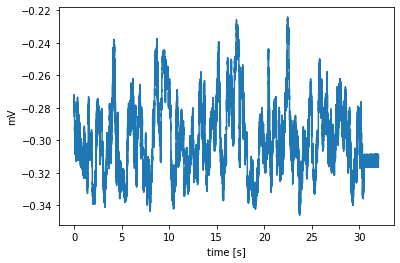

In [6]:
# generated by positioning a lightguide with a photodiode on the arena connected to a regular electrophysiology setup
test_data = np.load('data//test_data_photodiode.npy')
time      = test_data[:,0]
data      = test_data[:,1]

# plot
plt.figure()
ax = plt.subplot(111)
plt.plot(time, data)
ax.set_xlabel('time [s]')
ax.set_ylabel('mV')

## Reconstruct stimulus

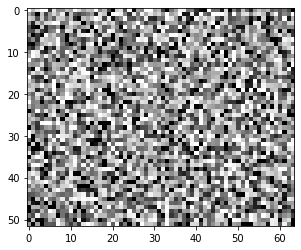

In [7]:
# specify parameters of the stimulus that was used to obtain the data
stimulus_name          = 'stimuli.default.GaussNoise_General'
stimulus_Nphi          = 64
stimulus_Nz            = 52
stimulus_time_constant = 0.2
stimulus_duration      = 30.0

# specify parameters of the recording
fs   = 10000  # acquisition framerate
data = pd.Series(data, index = time)
data = data[0::10] # sample down data because 10000 Hz means a lot of data, and this time precision is not necesarry if the stimulus itself has only 0.2 seconds time resolution

#####################
# mean subtract

baseline           = get_1st_order_LP_baseline(data, fs, time_constant = 60.0) # get a mean trace as a baseline, which is a lowpass filtered version of the signal
data_mean_subtract = data-baseline # subtract mean
data_mean_subtract = pd.DataFrame(data_mean_subtract)

# reconstruct stimulus
# depending on which stimulus was used the time constant plays a different role
# for GaussNoise_General:
#    - it is the time constant of a 1st order lowpass filter with which the random numbers were filterd along time
#    - it is given as float number in units of seconds, and should not be smaller than 0.016 (= 16ms = 1/60HZ), because of the refresh-rate of the monitor
# for BinarayNoise_DiscreteTime:
#    - it is the number of frames (given a 60Hz display), after which new random numbers are generated
#    - it should be an integer number
if stimulus_name == 'stimuli.default.GaussNoise_General':
    my_noise = recover_GaussNoise_General(duration = stimulus_duration, N_phi = stimulus_Nphi, N_z = stimulus_Nz, tau = stimulus_time_constant)
    fs_stimulus = 60.0
elif stimulus_name == "stimuli.default.BinaryNoise_DiscreteTime":
    my_noise = recover_BinaryNoise_DiscreteTime(duration = stimulus_duration, N_phi = stimulus_Nphi, N_z = stimulus_Nz, delta_s = stimulus_time_constant)
    fs_stimulus = 1/(stimulus_time_constant/60.)
    
    
# show stimulus
plt.imshow(my_noise[0,:,:], cmap = plt.get_cmap('Greys_r'), vmin = 0, vmax = 255)

## Reverse correlation

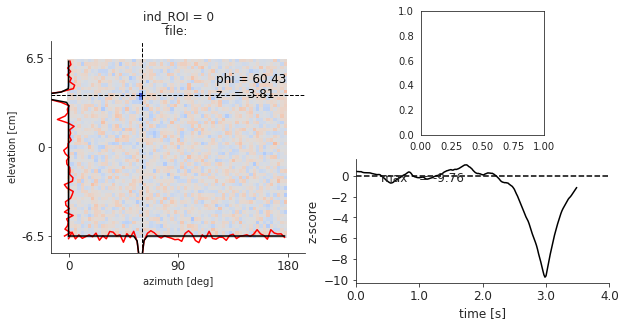

In [8]:
# run reverse correlation on multi-core processor
N_pool = -1
N_chunks = 100
T_past = 3.0
T_futu = 0.5

K_raw, K_norm, z_score_list = reverse_correlation_time_multi_core(data_mean_subtract, my_noise, fs_stimulus, T_past, T_futu, N_pool = N_pool, N_chunks = N_chunks)
K_norm = np.swapaxes(K_norm[:,:,::-1,:], 0, 2) # swap and flip axes according to "old" convention

#### analyse RF and show position

R_normalized, maxima, maxima_i, maxima_j, maxima_t, centers_i, centers_j, sigma_i, sigma_j, a_i, a_j = pre_analyse_rev_corr_2D(K_norm)
mean_image = np.zeros((10,10,R_normalized.shape[3]))
roi_masks  = np.zeros((10,10,R_normalized.shape[3]))
plot_pre_analysis_2D(R_normalized, mean_image, roi_masks, maxima, maxima_i, maxima_j, maxima_t, centers_i, centers_j, sigma_i, sigma_j, a_i, a_j, roi_bins = [], cmap = 'coolwarm')


plt.show()